**Kwaku Amo-Korankye - 10211100331<br>AI4126: Computational Perception<br>Bone Fracture Classification and Quality Evaluation Using Image Analysis**

Dataset Importation

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ahmedashrafahmed/bone-fracture")

print("Path to dataset files:", path)

c:\Users\Joel\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\Joel\.cache\kagglehub\datasets\ahmedashrafahmed\bone-fracture\versions\1


Importing Dependencies

In [2]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm

Reading the data

In [3]:
def data(dataset_path):
    images = []
    labels = []
    for subfolder in os.listdir(dataset_path):
        subfolder_path = os.path.join(dataset_path, subfolder)
        if not os.path.isdir(subfolder_path):
            continue
        for image_filename in os.listdir(subfolder_path):
            if image_filename.endswith(".jpg"):
                image_path = os.path.join(subfolder_path, image_filename)
                images.append(image_path)
                labels.append(subfolder)
    df = pd.DataFrame({'image': images, 'label': labels})
    return df

Loading the training dataset

In [4]:
train = data('C:/Users/Joel/.cache/kagglehub/datasets/ahmedashrafahmed/bone-fracture/versions/1/dataset/train')
train.head()

image      label
0  C:/Users/Joel/.cache/kagglehub/datasets/ahmeda...  fractured
1  C:/Users/Joel/.cache/kagglehub/datasets/ahmeda...  fractured
2  C:/Users/Joel/.cache/kagglehub/datasets/ahmeda...  fractured
3  C:/Users/Joel/.cache/kagglehub/datasets/ahmeda...  fractured
4  C:/Users/Joel/.cache/kagglehub/datasets/ahmeda...  fractured

Loading the test dataset

In [5]:
test = data('C:/Users/Joel/.cache/kagglehub/datasets/ahmedashrafahmed/bone-fracture/versions/1/dataset/test')
test.head()

image      label
0  C:/Users/Joel/.cache/kagglehub/datasets/ahmeda...  fractured
1  C:/Users/Joel/.cache/kagglehub/datasets/ahmeda...  fractured
2  C:/Users/Joel/.cache/kagglehub/datasets/ahmeda...  fractured
3  C:/Users/Joel/.cache/kagglehub/datasets/ahmeda...  fractured
4  C:/Users/Joel/.cache/kagglehub/datasets/ahmeda...  fractured

Loading the validation dataset

In [6]:
val=data('C:/Users/Joel/.cache/kagglehub/datasets/ahmedashrafahmed/bone-fracture/versions/1/dataset/val')
val.head()

image      label
0  C:/Users/Joel/.cache/kagglehub/datasets/ahmeda...  fractured
1  C:/Users/Joel/.cache/kagglehub/datasets/ahmeda...  fractured
2  C:/Users/Joel/.cache/kagglehub/datasets/ahmeda...  fractured
3  C:/Users/Joel/.cache/kagglehub/datasets/ahmeda...  fractured
4  C:/Users/Joel/.cache/kagglehub/datasets/ahmeda...  fractured

Visualizing the directories

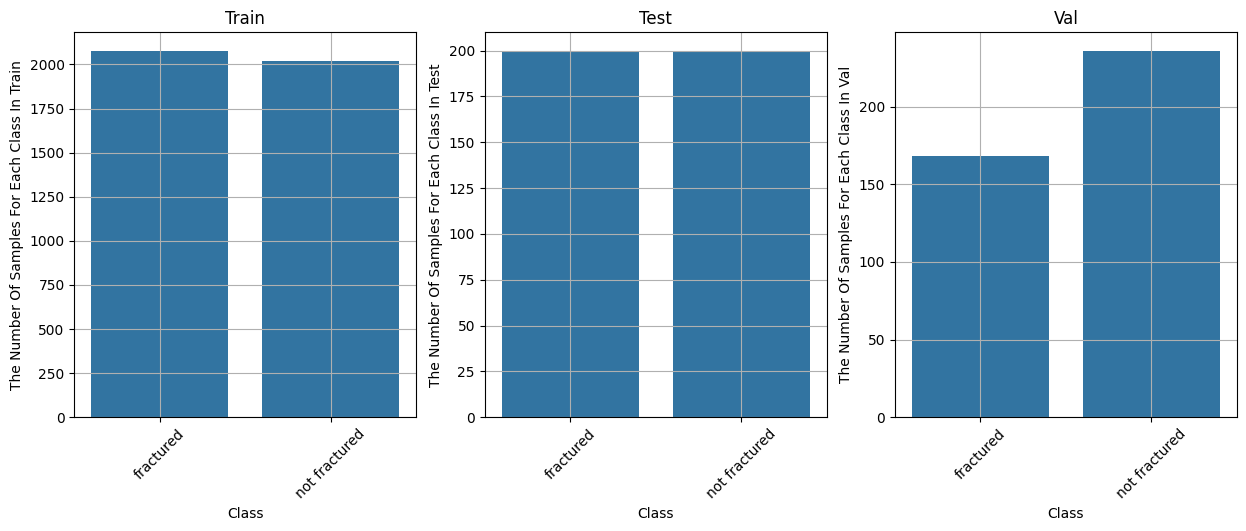

In [7]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
ax = sns.countplot(x=train.label)
ax.set_xlabel("Class")
ax.set_ylabel("The Number Of Samples For Each Class In Train")
plt.title('Train')
plt.grid(True)
plt.xticks(rotation=45)
plt.subplot(1,3,2)
ax = sns.countplot(x=test.label)
ax.set_xlabel("Class")
ax.set_ylabel("The Number Of Samples For Each Class In Test")
plt.title('Test')
plt.grid(True)
plt.xticks(rotation=45)
plt.subplot(1,3,3)
ax = sns.countplot(x=val.label)
ax.set_xlabel("Class")
ax.set_ylabel("The Number Of Samples For Each Class In Val")
plt.title('Val')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

Visualizing the dataset

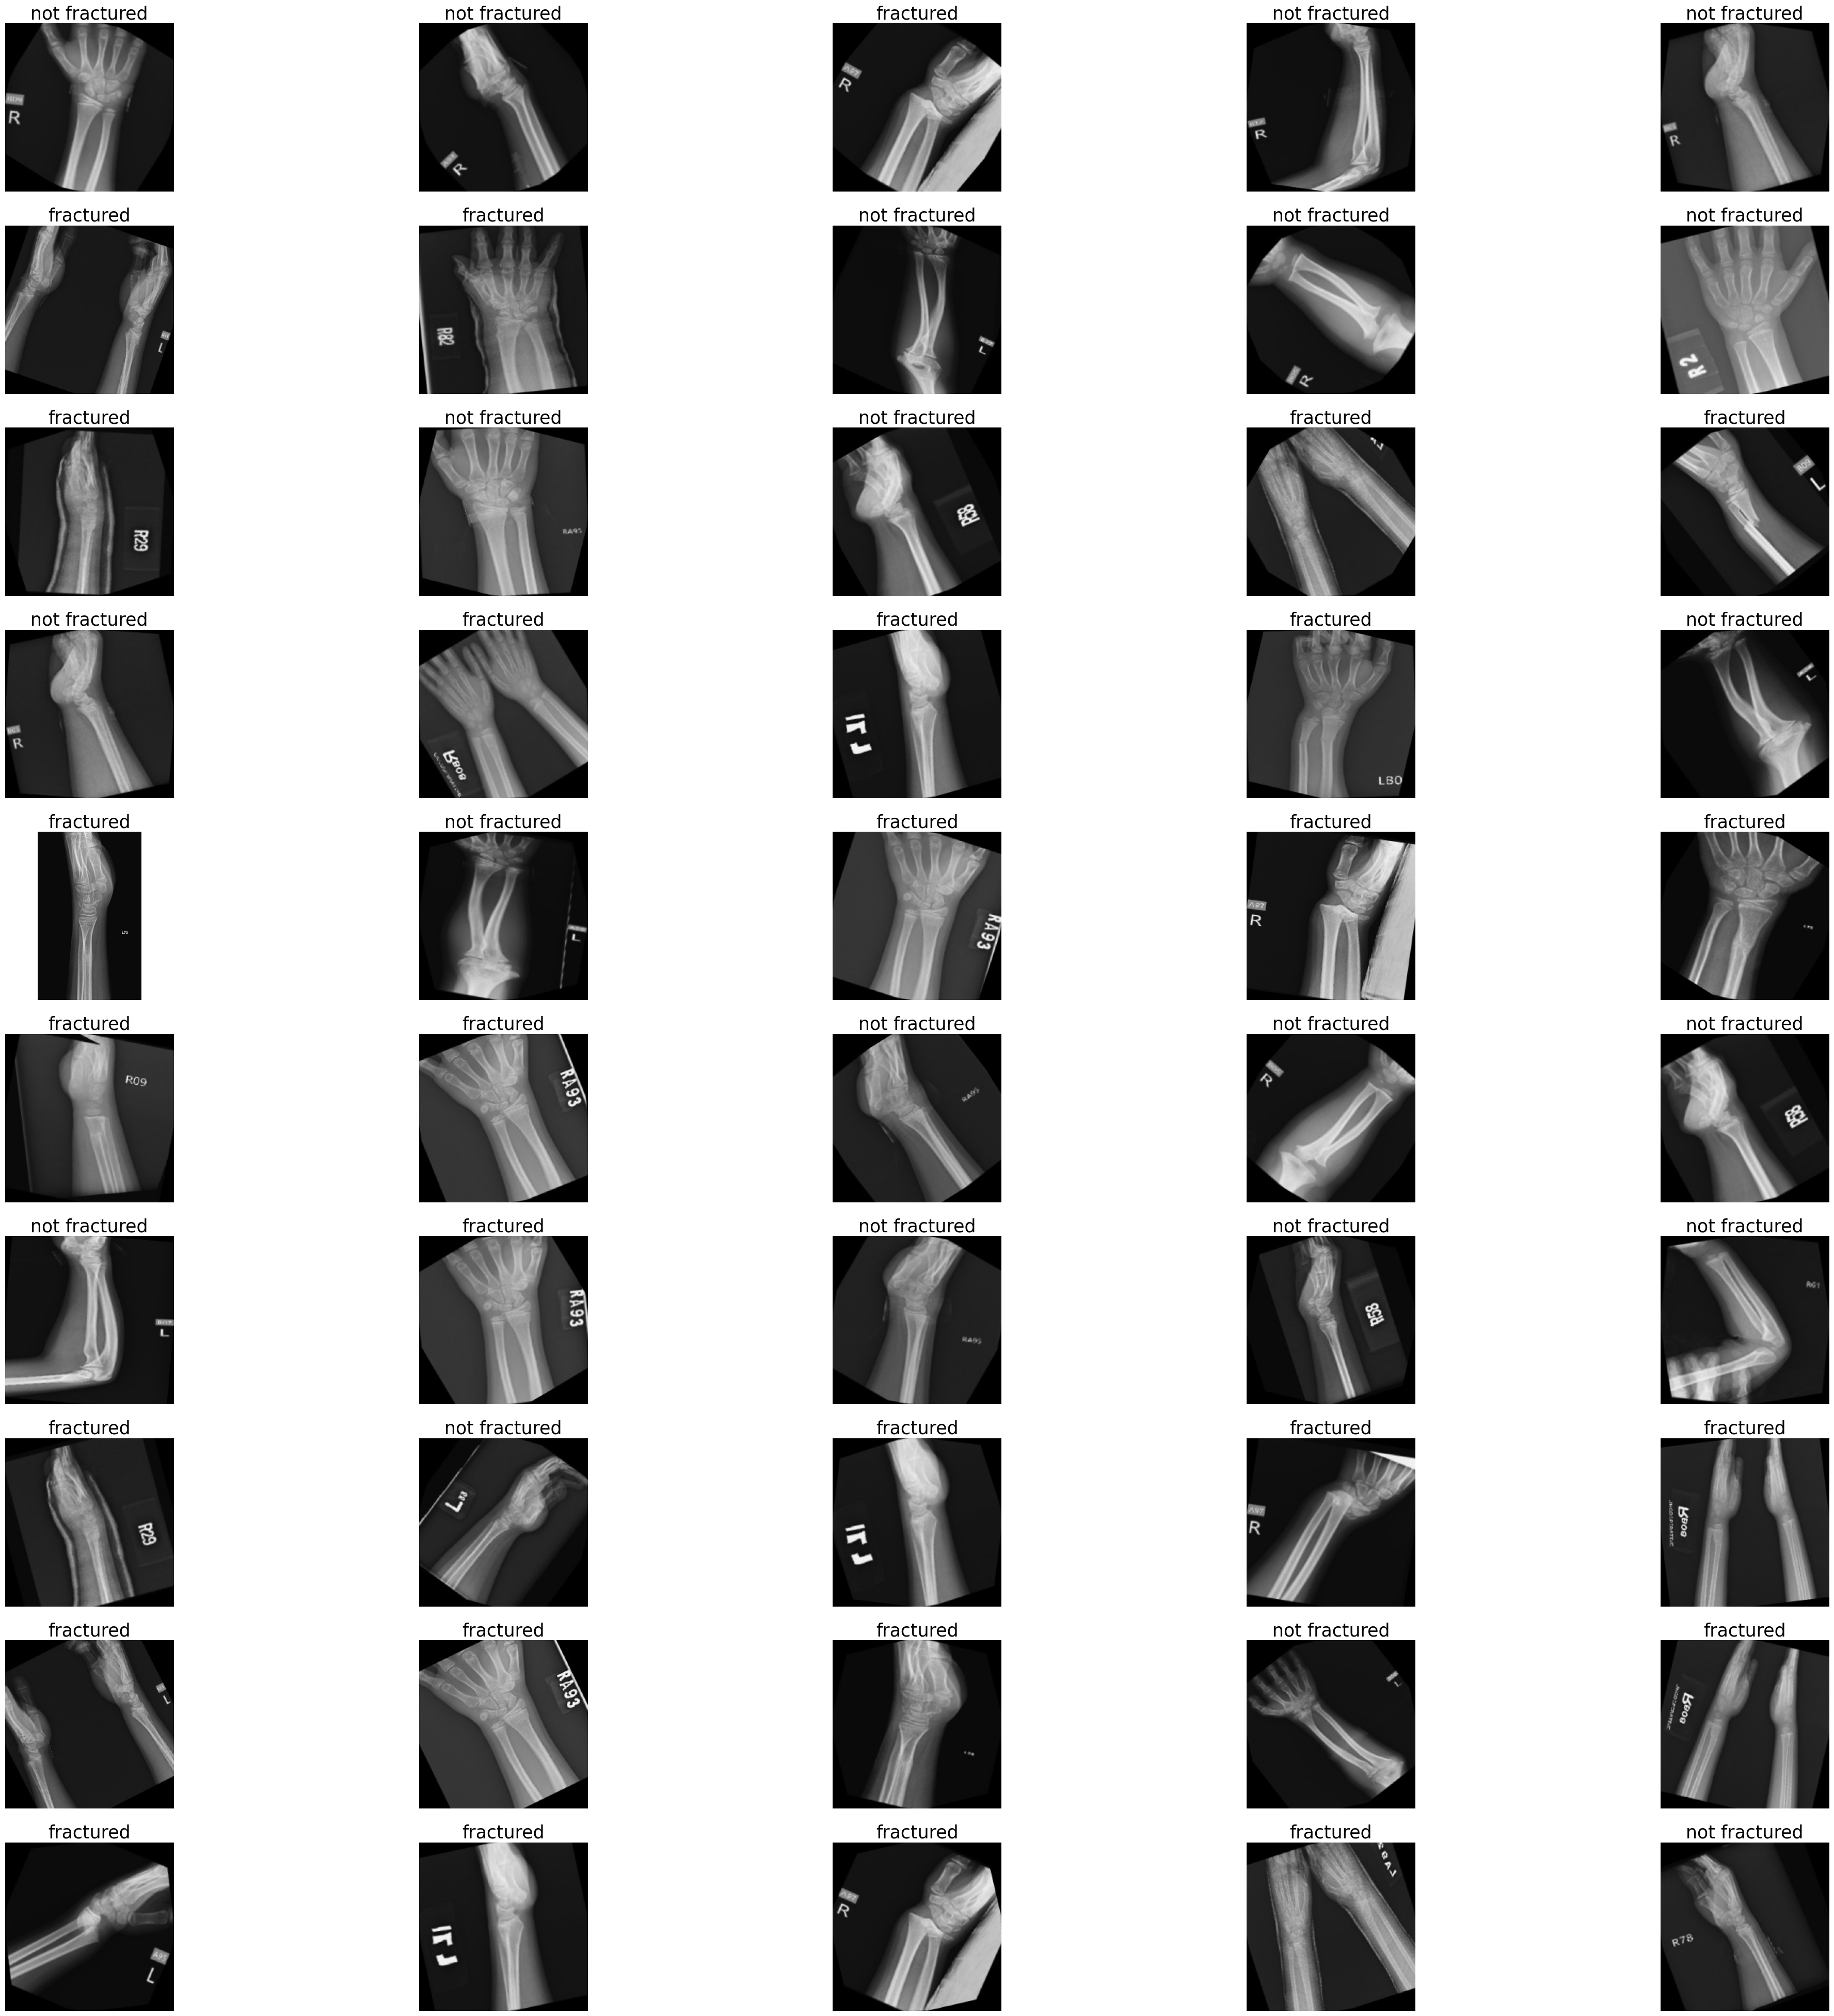

In [8]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(train),50)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(train.image[i])
    plt.imshow(img)
    plt.axis('off')
    plt.title(train.label[i],fontsize=25)

Performing Data Augmentation

In [9]:
image_size = (224, 224)
batch_size = 32
datagen = ImageDataGenerator(
    rescale=1./255
)
train_generator = datagen.flow_from_dataframe(
    train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)
test_generator = datagen.flow_from_dataframe(
    test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)
val_generator = datagen.flow_from_dataframe(
    val,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

Found 4097 validated image filenames belonging to 2 classes.
Found 399 validated image filenames belonging to 2 classes.
Found 404 validated image filenames belonging to 2 classes.


Model Development

In [10]:
class_num=1
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3),activation=tf.nn.relu,input_shape=(224,224,3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2,2)))
model.add(keras.layers.Conv2D(filters=64, kernel_size=(3,3),activation=tf.nn.relu))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2,2)))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Conv2D(filters=128, kernel_size=(3,3),activation=tf.nn.relu))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2,2)))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256,activation=tf.nn.relu))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Dense(128,activation=tf.nn.relu))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Dense(class_num,activation=tf.nn.sigmoid))
model.summary()

c:\Users\Joel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,278,593 (84.99 MB)

 Trainable params: 22,278,145 (84.98 MB)

 Non-trainable params: 448 (1.75 KB)

In [12]:
checkpoint_cb = ModelCheckpoint("bone_fracture_detection_model.keras", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=5, restore_best_weights=True)
model.compile(optimizer ='adam', loss='binary_crossentropy', metrics=['accuracy',keras.metrics.SpecificityAtSensitivity(0.5),keras.metrics.AUC()])
hist=model.fit(train_generator,epochs=10,validation_data=val_generator,callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/10


c:\Users\Joel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


129/129 ━━━━━━━━━━━━━━━━━━━━ 77s 574ms/step - accuracy: 0.6497 - auc: 0.6766 - loss: 5.1735 - specificity_at_sensitivity: 0.7501 - val_accuracy: 0.5842 - val_auc: 0.5000 - val_loss: 23.3591 - val_specificity_at_sensitivity: 0.0000e+00
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 83s 641ms/step - accuracy: 0.8039 - auc: 0.8653 - loss: 1.0751 - specificity_at_sensitivity: 0.9339 - val_accuracy: 0.5842 - val_auc: 0.5000 - val_loss: 21.5212 - val_specificity_at_sensitivity: 0.0000e+00
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 87s 677ms/step - accuracy: 0.8508 - auc: 0.9312 - loss: 0.4667 - specificity_at_sensitivity: 0.9803 - val_accuracy: 0.6436 - val_auc: 0.5959 - val_loss: 11.6877 - val_specificity_at_sensitivity: 0.2024
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 87s 676ms/step - accuracy: 0.8823 - auc: 0.9549 - loss: 0.3477 - specificity_at_sensitivity: 0.9880 - val_accuracy: 0.9134 - val_auc: 0.9741 - val_loss: 0.3071 - val_specificity_at_sensitivity: 0.9702
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━

Model Evaluation

In [13]:
hist_=pd.DataFrame(hist.history)
hist_

accuracy       auc      loss  specificity_at_sensitivity  val_accuracy  \
0  0.711496  0.748229  3.309187                    0.819057      0.584158   
1  0.811325  0.878484  0.915851                    0.947546      0.584158   
2  0.857945  0.937564  0.444926                    0.981713      0.643564   
3  0.891628  0.962085  0.313566                    0.991819      0.913366   
4  0.926532  0.977540  0.219378                    0.991338      0.957921   
5  0.926532  0.975345  0.247124                    0.987007      0.928218   
6  0.936295  0.983374  0.176023                    0.994706      0.972772   
7  0.948255  0.985871  0.152849                    0.990375      0.980198   
8  0.946790  0.988860  0.146231                    0.995669      0.995049   
9  0.950940  0.988113  0.159579                    0.994225      0.982673   

    val_auc   val_loss  val_specificity_at_sensitivity  
0  0.500000  23.359066                        0.000000  
1  0.500000  21.521214                        0.000000  
2  0.595894  11.687655                        0.202381  
3  0.974084   0.307057                        0.970238  
4  0.992206   0.103372                        0.994048  
5  0.968964   0.288116                        0.970238  
6  0.997692   0.062582                        1.000000  
7  0.994842   0.064369                        0.994048  
8  0.999950   0.009715                        1.000000  
9  0.999596   0.050086                        1.000000

Plotting the Evaluation Graph

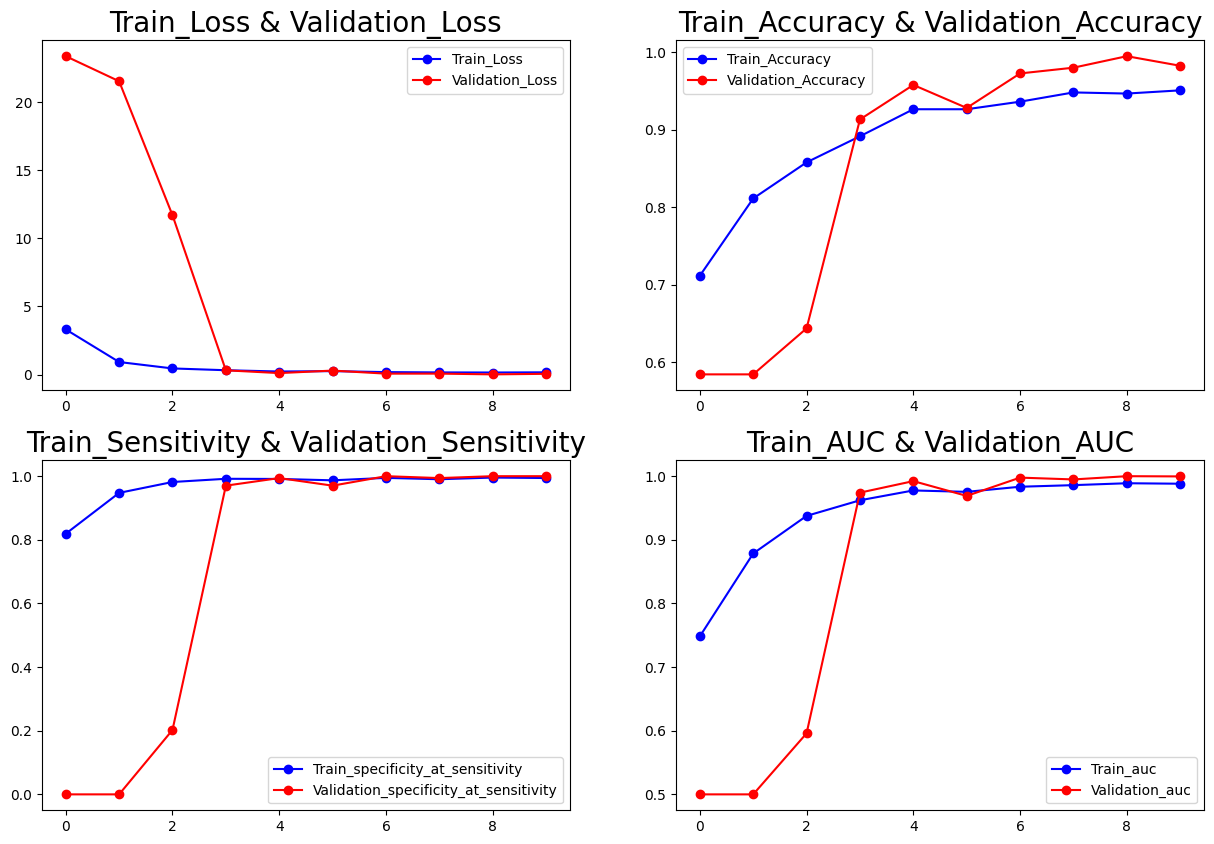

In [14]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(hist_['loss'],'b-o',label='Train_Loss')
plt.plot(hist_['val_loss'],'r-o',label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(2,2,2)
plt.plot(hist_['accuracy'],'b-o',label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],'r-o',label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.subplot(2,2,3)
plt.plot(hist_['specificity_at_sensitivity'],'b-o',label='Train_specificity_at_sensitivity')
plt.plot(hist_['val_specificity_at_sensitivity'],'r-o',label='Validation_specificity_at_sensitivity')
plt.title('Train_Sensitivity & Validation_Sensitivity',fontsize=20)
plt.legend()
plt.subplot(2,2,4)
plt.plot(hist_['auc'],'b-o',label='Train_auc')
plt.plot(hist_['val_auc'],'r-o',label='Validation_auc')
plt.title('Train_AUC & Validation_AUC',fontsize=20)
plt.legend()
plt.show()

In [15]:
score, acc,sensitivity,auc = model.evaluate(test_generator)
print('Test Loss =', score)
print('Test Accuracy =', acc)
print('Test Sensitivity =', sensitivity)
print('Test AUC =', auc)

c:\Users\Joel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.9809 - auc: 0.5707 - loss: 0.0576 - specificity_at_sensitivity: 0.5714 
Test Loss = 0.10584921389818192
Test Accuracy = 0.9799498915672302
Test Sensitivity = 1.0
Test AUC = 0.9965954422950745


Testing the Model

In [16]:
y_test =test_generator.classes
predictions = model.predict(test_generator)
y_pred = np.where(predictions >= 0.5, 1, 0)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})
df

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step


Actual  Prediction
0         0           0
1         0           0
2         0           0
3         0           0
4         0           0
..      ...         ...
394       1           1
395       1           1
396       1           1
397       1           1
398       1           1

[399 rows x 2 columns]

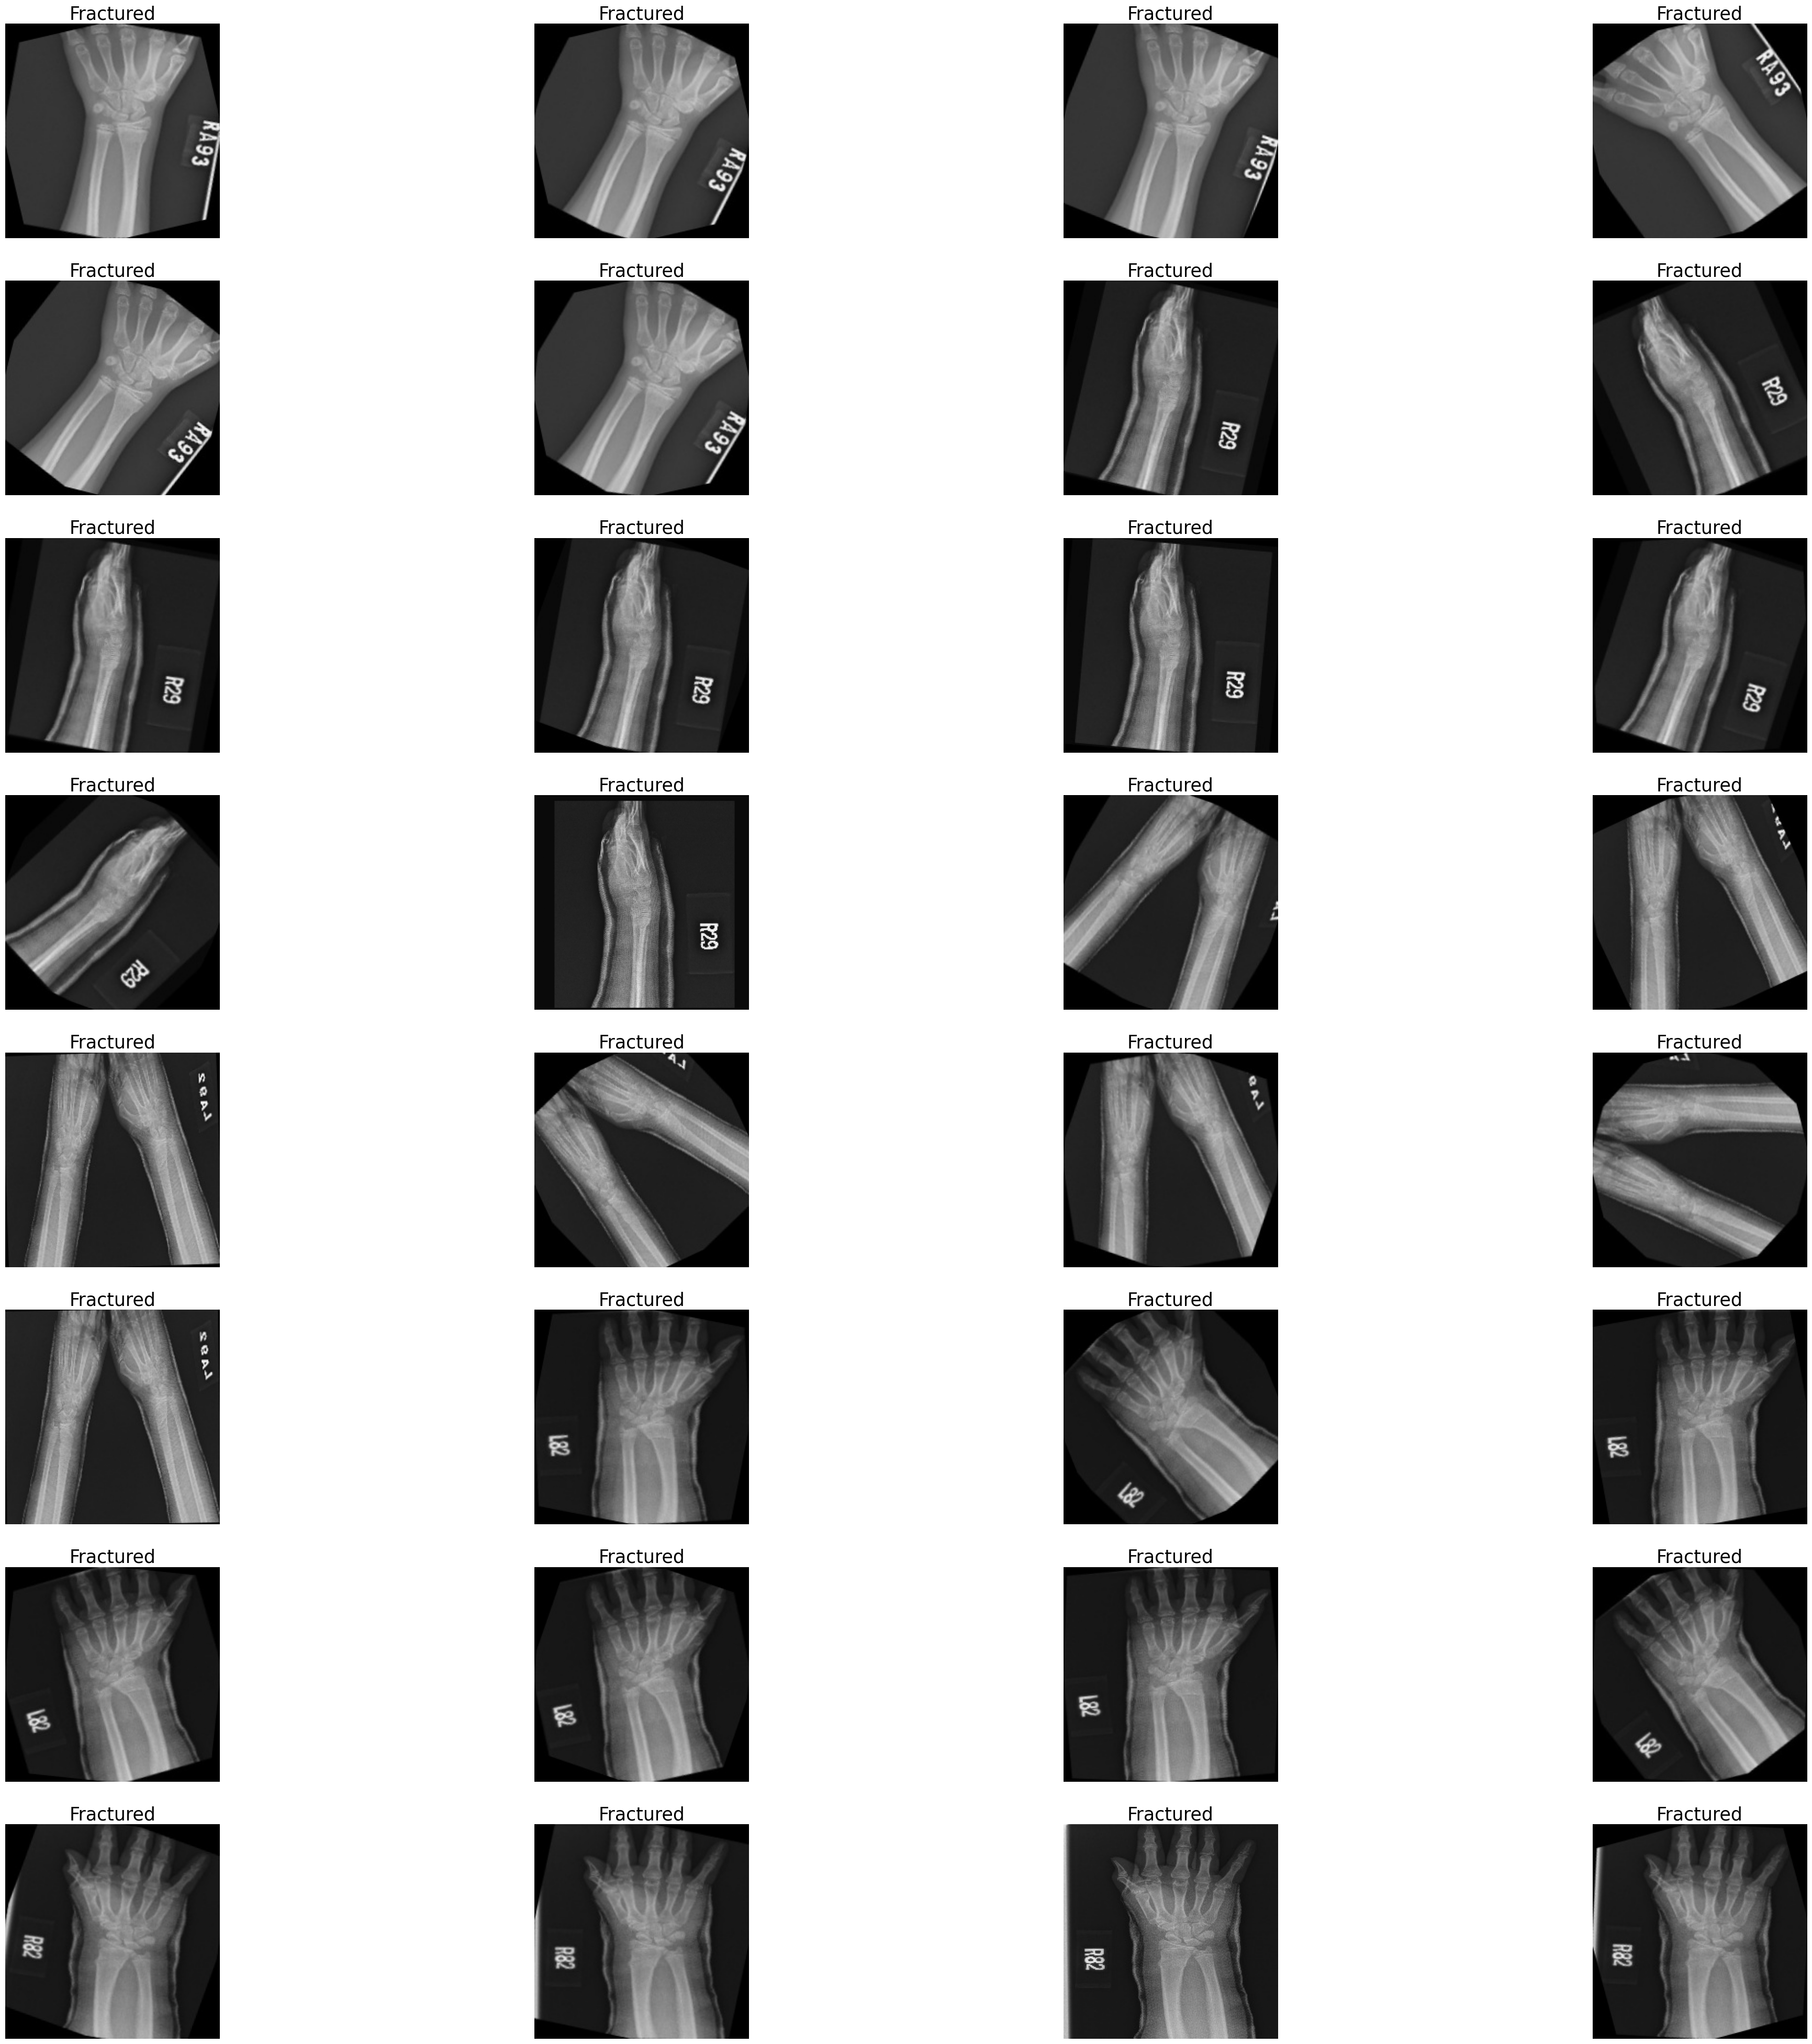

In [17]:
class_names=['Fractured', 'Not Fractured']
batch = next(test_generator)
images= batch[0]
plt.figure(figsize=(50,50))
for n in range(32):
    plt.subplot(8,4,n+1)
    plt.imshow(images[n])
    plt.axis('off')
    plt.title(class_names[int(y_test[n])],fontsize=25)

Confusion Matrix

array([[195,   4],
       [  4, 196]])

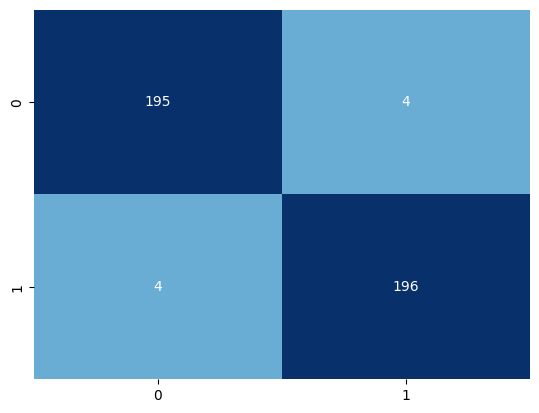

In [18]:
CM = confusion_matrix(y_test,y_pred)
sns.heatmap(CM,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

Classification Report

In [19]:
ClassificationReport = classification_report(y_test,y_pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.98      0.98      0.98       199
           1       0.98      0.98      0.98       200

    accuracy                           0.98       399
   macro avg       0.98      0.98      0.98       399
weighted avg       0.98      0.98      0.98       399

